# Requirements
### carto-test.ipynb must be in the same folder as the docker image.

Some required packages: in

In [13]:
import requests as req
import pandas as pd
import json
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from cartoframes.viz import Layer, color_bins_style, popup_element
from pandas import read_csv
from geopandas import GeoDataFrame, points_from_xy

### Set Path to docker file 

In [2]:
path= '/Users/eve/dockers/carto-test/'

## Get Restaurant

### getRestaurants is a method deployed on a docker-compose enviroment

In [3]:
resp = req.get("http://localhost:4000/getRestaurants")


In [4]:
if resp.ok:
    filepath= path + resp.json()['filename']
else:
    raise TypeError("x is of type {type(x).__name__}, should be str")

## Read the file to pandas 

In [5]:
data = pd.read_csv(filepath)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4167 entries, 0 to 4166
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lon            4167 non-null   float64
 1   lat            4167 non-null   float64
 2   cluster_id     4167 non-null   int64  
 3   cluster_db_id  4167 non-null   int64  
 4   poi_id         4167 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 162.9 KB


In [7]:
gdf = GeoDataFrame(data, geometry=points_from_xy(data['lon'], data['lat']))
gdf.head()


,lon,lat,cluster_id,cluster_db_id,poi_id,geometry
0,-3.686247,40.423682,0,0,3903740912,POINT (-3.68625 40.42368)
1,-3.692442,40.430437,0,-1,4942808513,POINT (-3.69244 40.43044)
2,-3.794083,40.438178,0,-1,4966765724,POINT (-3.79408 40.43818)
3,-3.708830,40.413677,0,1,4349458099,POINT (-3.70883 40.41368)
4,-3.702904,40.421296,0,-1,6042650475,POINT (-3.70290 40.42130)


### Raw data plot

In [8]:
Layer(gdf)

### KMEANS CLUSTER CLASIFFICATION PLOT

In [9]:
Layer(
    gdf,
    color_bins_style('cluster_km_id', method='equal', bins=gdf.cluster_id.unique().size),
    popup_hover=[popup_element('cluster_km_id', 'Cinema')],
    title='Cinemas'
)

### DBSCAN CLUSTER CLASIFFICATION PLOT

In [10]:
interval=gdf['cluster_db_id'].quantile([.1, .25, .5, .75])
gdf_noout=gdf[gdf.cluster_db_id != -1]
interval=gdf_noout['cluster_db_id'].quantile([.1, .25, .5, .75])
Layer(
    gdf_noout,
    color_bins_style('cluster_db_id', method='quantiles', bins=gdf_noout['cluster_db_id'].unique().size,breaks=interval),
    popup_hover=[popup_element('cluster_db_id', 'Cinema')],
    title='Cinemas'
)

Esta es la query que he empleado paraa sacar los datos = """

    WITH bounding_box AS (
        SELECT ST_GEOGFROMTEXT('polygon((-3.93455628 40.25387182, -3.93455628 40.57085727, -3.31993445 40.57085727, -3.31993445 40.25387182,-3.93455628 40.25387182))') madrid
    ),
        cinemas as (SELECT 
        ST_UNION_AGG(ST_BUFFER(the_geom,150)) as area
    FROM 
      `carto-ps-bq-developers.data_test.osm_spain_pois`
      where  amenity like '%cinema%'
    )
    select id,lon,lat,amenity,shop,leisure,sport,building,entrance,crossing, the_geom from bounding_box bb, cinemas c,`carto-ps-bq-developers.data_test.osm_spain_pois` r  
    where amenity like '%restaurant%'
    and ST_CONTAINS(c.area,r.the_geom) = FALSE
    and ST_CONTAINS(bb.madrid,r.the_geom)


    """
    

# Analysis of the data to perform DBSCAN

### Some analysis to undestand the data

In [11]:
from sklearn.cluster import KMeans, DBSCAN
#from sklearn.metrics import silhouette_scor
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score


In [12]:
data.duplicated(subset=['lon','lat']).values.any()
data.isna().values.any()

False

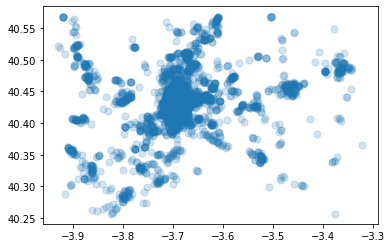

In [13]:
COOR = np.array(data[['lon', 'lat']], dtype='float64')
plt.scatter(COOR[:,0], COOR[:,1], alpha=0.2, s=50)

In [14]:
COOR = np.array(data[['lon', 'lat']], dtype='float64')
model = DBSCAN(eps=0.0005, min_samples=5).fit(COOR)
class_predictions = model.labels_
gdf['cluster_db_id'] = class_predictions

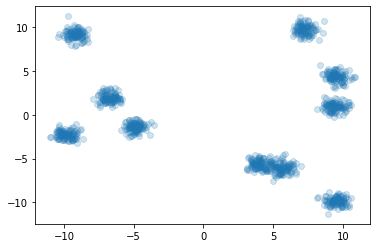

In [15]:
X_blobs, _ = make_blobs(n_samples=1000, centers=10, n_features=2, 
                        cluster_std=0.5, random_state=4)
plt.scatter(X_blobs[:,0], X_blobs[:,1], alpha=0.2)


In [16]:
model = DBSCAN(eps=0.0005, min_samples=5).fit(COOR)
class_predictions = model.labels_

gdf['CLUSTERS_DBSCAN'] = class_predictions

In [17]:
gdf['CLUSTERS_DBSCAN'].unique()

array([ 0, -1,  1,  2, 62,  3,  4,  5,  6, 88,  7, 74,  8, 75,  9, 10, 11,
       12, 13, 14, 81, 15, 16, 17, 22, 18, 19, 20, 21, 30, 23, 24, 54, 58,
       25, 26, 27, 28, 29, 66, 31, 63, 32, 33, 34, 35, 78, 39, 36, 46, 48,
       37, 38, 55, 65, 40, 41, 57, 42, 45, 72, 86, 43, 44, 51, 47, 73, 49,
       50, 91, 52, 53, 56, 77, 82, 59, 60, 61, 64, 80, 83, 67, 84, 68, 69,
       76, 70, 71, 92, 79, 93, 89, 85, 90, 87])

In [20]:
    
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(COOR[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])

Number of clusters found: 95
Number of outliers found: 3061
Silhouette ignoring outliers: 0.4969910196815954


In [21]:
gdf_noout=gdf[class_predictions!=-1]
interval=gdf_noout['CLUSTERS_DBSCAN'].quantile([.1, .25, .5, .75])

In [22]:
Layer(
    gdf_noout,
    color_bins_style('CLUSTERS_DBSCAN', method='quantiles', bins=gdf_noout['CLUSTERS_DBSCAN'].unique().size,breaks=interval),
    popup_hover=[popup_element('CLUSTERS_DBSCAN', 'Cinema',format=".2f")],
    title='Cinemas'
)

# A KMEANS GEO APROACH

In [4]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import LabelEncoder
import pathlib
from google.cloud import bigquery
from google.cloud.bigquery.client import Client
from sklearn.cluster import DBSCAN

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [6]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/eve/Downloads/gc_credentials.json"


In [9]:
query_string = """

    WITH bounding_box AS (
        SELECT ST_GEOGFROMTEXT('polygon((-3.93455628 40.25387182, -3.93455628 40.57085727, -3.31993445 40.57085727, -3.31993445 40.25387182,-3.93455628 40.25387182))') madrid
    ),
        cinemas as (SELECT 
        ST_UNION_AGG(ST_BUFFER(the_geom,150)) as area
    FROM 
      `carto-ps-bq-developers.data_test.osm_spain_pois`
      where  amenity like '%cinema%'
    )
    select id,lon,lat,amenity,shop,leisure,sport,building,entrance,crossing, the_geom from bounding_box bb, cinemas c,`carto-ps-bq-developers.data_test.osm_spain_pois` r  
    where amenity like '%restaurant%'
    and ST_CONTAINS(c.area,r.the_geom) = FALSE
    and ST_CONTAINS(bb.madrid,r.the_geom)


    """

In [10]:
bqclient = bigquery.Client()
#Prepare Data --
restaurants = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
    )
)

In [11]:

attributescode = []
attributes = ['shop', 'leisure', 'sport','building', 'entrance', 'crossing']
lb_make = LabelEncoder()

#Prepare Data --
for atrib in attributes:
    newlabel=str(atrib+"code")
    restaurants[newlabel] = lb_make.fit_transform(restaurants[atrib])
    attributescode.append(newlabel)

#Cluster --

In [12]:

restaurants_geo = gpd.GeoDataFrame(restaurants, geometry=gpd.points_from_xy(restaurants.lon, restaurants.lat))
restaurants_geo.crs = {'init': u'epsg:4326'}
kmeans5 = cluster.KMeans(n_clusters=5).fit(restaurants_geo[['lon','lat']])
restaurants_geo['cluster_id'] = kmeans5.labels_
restaurants_geo['poi_id'] = restaurants_geo["id"]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [14]:
gdf=restaurants_geo
Layer(
    gdf,
    color_bins_style('cluster_id', method='equal', bins=gdf.cluster_id.unique().size),
    popup_hover=[popup_element('cluster_id', 'Cinema')],
    title='Cinemas'
)

## Acknowledgments:
  ####  Medium. Clustering Geo-location : DBSCAN  https://medium.com/analytics-vidhya/clustering-geo-location-dbscan-cadb33b0442e#:~:text=Applications%20with%20Noise)-,DBSCAN%20(Density%2Dbased%20spatial%20clustering%20of%20applications%20with%20noise),from%20clusters%20of%20low%20density.
   ####  GitHub project [not mine]: https://github.com/memeghaj10/Clustering-Geolocation-Data-Intelligently-in-Python
   
   ##### Juan Luis Ruiz Tagle me ha sugerido que habia algun otro metodo para clusterizar si habia tantos nulos. 



### Otro metodo alternativo que no me da tiempo es analizar los disntintos amenities que tiene cada restaurante cerca, creando nuevas labels. 